# Prepare Environment

Load necessary modules and attempt to compile the GrOpt library if it isn't already

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import gropt
from helper_utils import *

%matplotlib inline

# GrOpt

### Gradient Optimization Toolbox 
#### Written in C (for compiling on scanners), with wrappers in Python and Matlab for prototyping

Ideally **_any_** waveform can be described by a set of constraints

Currently implemented in various forms on Siemens and GE scanners

***

##### Example 1: Phase Encoding Gradient

#### Constraints on:
- Maximum gradient amplitude: params['gmax']
- Maximum slew rate: params['smax']
- Zero gradient moment = 11.74 (mT*ms)/m (The area needed to encode a 1mm spatial resolution line in k-space)

Waveform duration = 0.63 ms


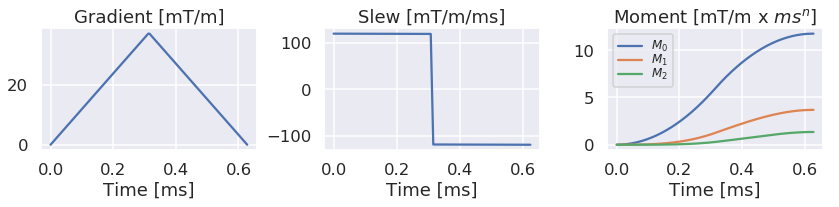

In [15]:
params = {}
params['mode'] = 'free' # Free mode indicates we are in a feasibility search, i.e. no objective function
params['dt'] = 4e-6     # Raster time of the gradient waveform being optimized
params['gmax'] = 50     # Maximum gradient amplitude, mT/m
params['smax'] = 120.0  # Maximum slew rate, mT/m/ms 

# Moment parameters have many options, reading the docs is necessary
# Currently, the input moment parameters used here are: 
#      2nd input: moment of interest, zero moment
#      6th input: desired 0th moment, 11.75
#      7th input: moment tolerance, 1.0e-3 
params['moment_params'] = [[0, 0, 0, -1, -1, 11.75, 1.0e-3]]



G, T_min = get_min_TE(params, max_TE = 2) # max_TE = 2 means it will search all waveforms between 0 and 2ms
print('Waveform duration =', round(T_min,2), 'ms')
plot_waveform(G, params, plot_moments = True, plot_eddy = False, plot_pns = False, plot_slew = True)

#### Reduce gmax from 50mT/m to 20mT/m to see the impact

Waveform duration = 0.76 ms


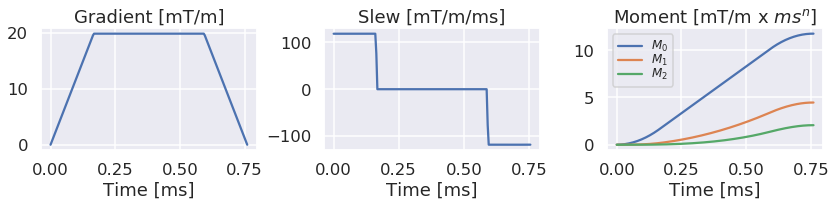

In [14]:
params = {}
params['mode'] = 'free'
params['smax'] = 120.0
params['moment_params'] = [[0, 0, 0, -1, -1, 11.75, 1.0e-3]]
params['dt'] = 4e-6

# ************
# gmax changed to 20 mT/m 
# ************
params['gmax'] = 20


G, T_min = get_min_TE(params, max_TE = 2)
print('Waveform duration =', round(T_min,2), 'ms')
plot_waveform(G, params, plot_moments = True, plot_eddy = False, plot_pns = False, plot_slew = True)

#### Add velocity compensation to the waveform by adding the constraint M1=0

Waveform duration = 1.29 ms


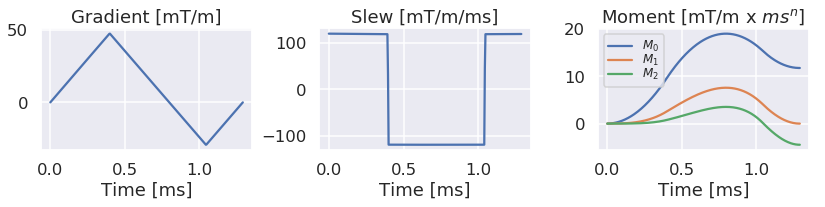

In [16]:
params = {}
params['mode'] = 'free'
params['gmax'] = 50
params['smax'] = 120.0
params['dt'] = 4e-6
params['moment_params'] = [[0, 0, 0, -1, -1, 11.75, 1.0e-3]]

# ************
# Additional moment constraint added for M1 = 0
# ************
params['moment_params'].append([0, 1, 0, -1, -1, 0, 1.0e-3])


G, T_min = get_min_TE(params, max_TE = 2.5)
print('Waveform duration =', round(T_min,2), 'ms')
plot_waveform(G, params, plot_moments = True, plot_eddy = False, plot_pns = False, plot_slew = True)

#### Add acceleration compensation to the waveform by adding the constraint M2=0

Waveform duration = 2.35 ms


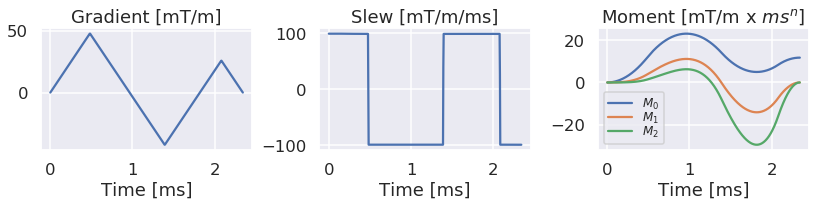

In [24]:
params = {}
params['mode'] = 'free'
params['gmax'] = 50
params['smax'] = 100.0
params['dt'] = 4e-6
params['moment_params'] = [[0, 0, 0, -1, -1, 11.75, 1.0e-3]]
params['moment_params'].append([0, 1, 0, -1, -1, 0, 1.0e-3])

# ************
# Additional moment constraint added for M2 = 0
# ************
params['moment_params'].append([0, 2, 0, -1, -1, 0, 1.0e-3])


G, T_min = get_min_TE(params, max_TE = 2.6)
print('Waveform duration =', round(T_min,2), 'ms')
plot_waveform(G, params, plot_moments = True, plot_eddy = False, plot_pns = False, plot_slew = True)

### Peripheral Nerve Stimulation (PNS) control

If we use the full power of the gradient slew rates, the same gradient can be played much faster, but PNS will become problematic

Waveform duration = 1.72 ms


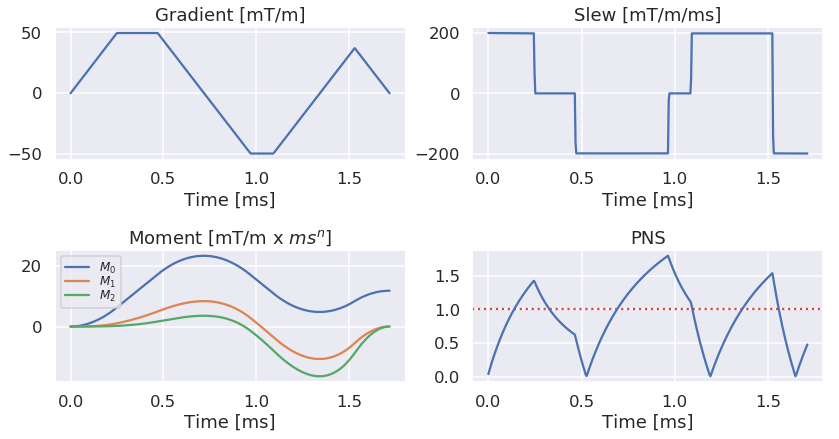

In [25]:
params = {}
params['mode'] = 'free'
params['gmax'] = 50
params['moment_params'] = [[0, 0, 0, -1, -1, 11.75, 1.0e-3]]
params['moment_params'].append([0, 1, 0, -1, -1, 0, 1.0e-3])
params['moment_params'].append([0, 2, 0, -1, -1, 0, 1.0e-3])
params['dt'] = 4e-6

# ************
# Increases slew rate to 200
# ************
params['smax'] = 200.0


G, T_min = get_min_TE(params, max_TE = 2)
print('Waveform duration =', round(T_min,2), 'ms')
plot_waveform(G, params, plot_moments = True, plot_eddy = False, plot_pns = True, plot_slew = True)

#### We can keep the maximum slew rate (200mT/m/ms) and add a PNS constraint to keep PNS < 1.0

Waveform duration = 1.98 ms


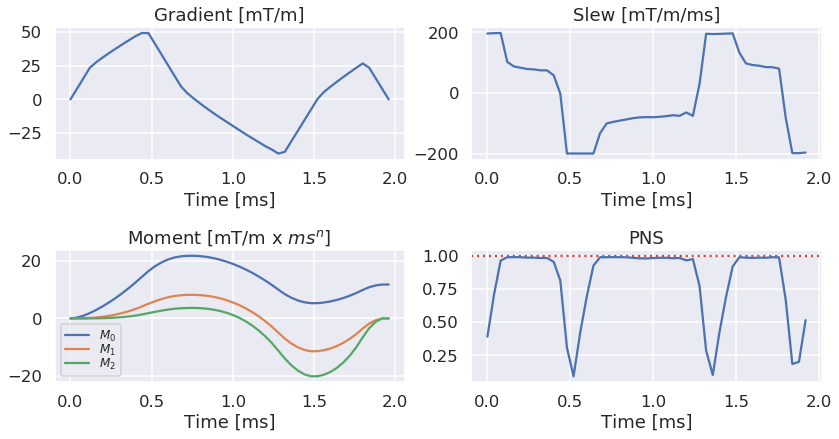

In [7]:
params = {}
params['mode'] = 'free'

params['gmax'] = 50
params['smax'] = 200.0

params['moment_params'] = [[0, 0, 0, -1, -1, 11.75, 1.0e-3]]
params['moment_params'].append([0, 1, 0, -1, -1, 0, 1.0e-3])
params['moment_params'].append([0, 2, 0, -1, -1, 0, 1.0e-3])
params['dt'] = 40e-6

# ************
# Add PNS contraint
# ************
params['pns_thresh'] = 1.0

G, T_min = get_min_TE(params, min_TE = 1.6, max_TE = 2.2)
print('Waveform duration =', round(T_min,2), 'ms')
plot_waveform(G, params, plot_moments = True, plot_eddy = False, plot_pns = True, plot_slew = True)

## Example 2: Diffusion Encoding Gradients

#### Constraints on:
- Maximum gradient amplitude: params['gmax']
- Maximum slew rate: params['smax']
- Zero gradient moment = 0 (mT*ms)/m
- Add objective function to maximize b-value
- Add constraint to turn gradients off during excitation RF (T_90), refocusing RF (T_180), and ADC readout (T_redout)

Minimum TE = 68.67 ms


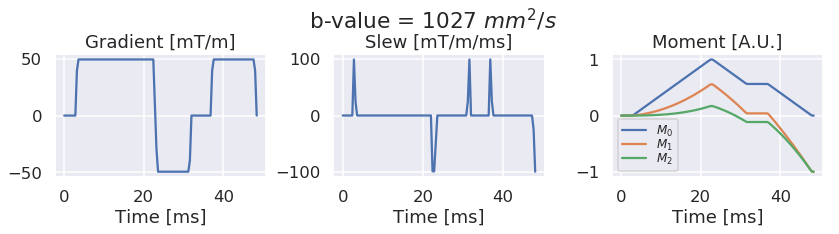

Minimum TE = 74.17 ms


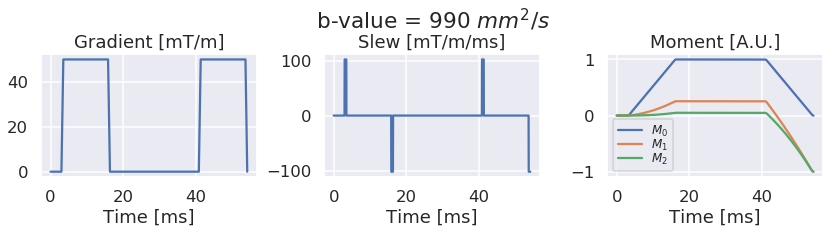

In [26]:
params = {}
params['mode'] = 'diff_bval'   # Objective function that maximizes b-value
params['gmax'] = 50            # Maximum gradient amplitude, mT/m
params['smax'] = 100           # Maximum slew rate, mT/m/ms
params['MMT'] = 0              # Nulling M0
params['T_readout'] = 20       # Time from start to center of readout, ms
params['T_90'] = 3             # Duration of excitation RF pulse, ms
params['T_180'] = 5            # Duration of refocusing RF pulse, ms
params['b'] = 1000             # Diffusion b-value, s/mm^2
params['dt'] = 400e-6          # Raster time of the gradient waveform being optimized

# Convex Optimized Diffusion Encoding (CODE)
G_min, T_min = get_min_TE(params, bval=params['b'], min_TE = 40, max_TE = 120)
print('Minimum TE =', round(T_min,2), 'ms')
plot_waveform(-1*G_min, params, plot_moments = True, plot_eddy = False, plot_pns = False, plot_slew = True)
plt.show(plot_waveform)

# Conventional Monopolar
Mono, TE, b, params = monopolar_diffusion(params)
params['TE'] = TE/100 + params['T_readout']*1000
print('Minimum TE =', round(params['TE'],2), 'ms')
plot_waveform(Mono, params, plot_moments = True, plot_eddy = False, plot_pns = False, plot_slew = True)
plt.show(plot_waveform)

#### We can constrain for M0=M1=0 for conventional and optimized diffusion encoding methods, which mitigate signal losses due to constant moving tissue

Minimum TE = 92.66 ms


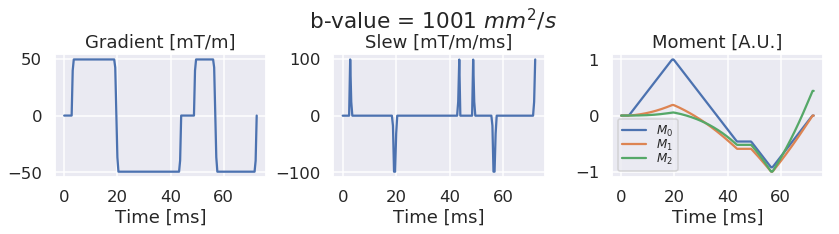

Minimum TE = 110.98 ms


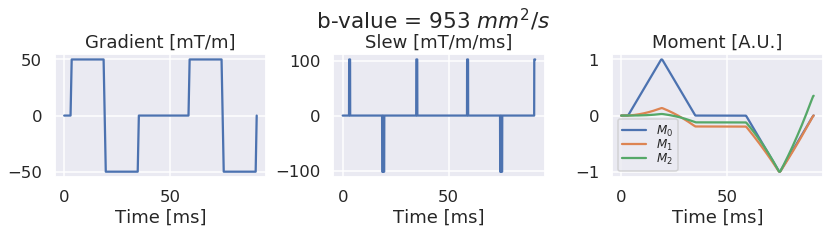

In [9]:
params = {}
params['mode'] = 'diff_bval'
params['gmax'] = 50            # Maximum gradient amplitude, mT/m
params['smax'] = 100           # Maximum slew rate, mT/m/ms
params['T_readout'] = 20       # Time from start to center of EPI readout, ms
params['T_90'] = 3             # Duration of excitation pulse, ms
params['T_180'] = 5            # Duration of refocusing pulse, ms
params['b'] = 1000             # Diffusion b-value, s/mm^2
params['dt'] = 400e-6

# ************
# M0 and M1 nulling
# ************
params['MMT'] = 1              # Nulling M0 and M1



# Convex Optimized Diffusion Encoding (CODE)
G_min, T_min = get_min_TE(params, bval=params['b'], min_TE = 40, max_TE = 120)
print('Minimum TE =', round(T_min,2), 'ms')
plot_waveform(G_min, params, plot_moments = True, plot_eddy = False, plot_pns = False, plot_slew = True)
plt.show(plot_waveform)

# Conventional Bipolar
Bipolar, TE, b, params = bipolar_diffusion(params)
params['TE'] = TE/100 + params['T_readout']*1000
print('Minimum TE =', round(params['TE'],2), 'ms')
plot_waveform(Bipolar, params, plot_moments = True, plot_eddy = False, plot_pns = False, plot_slew = True)
plt.show(plot_waveform)

#### We can constrain for M0=M1=M2=0 for conventional and optimized diffusion encoding methods, which mitigate signal losses due to constant moving AND accelerating tissue

Minimum TE = 111.02 ms


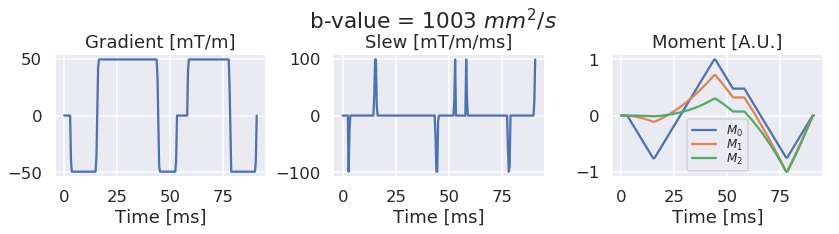

Minimum TE = 130.8 ms


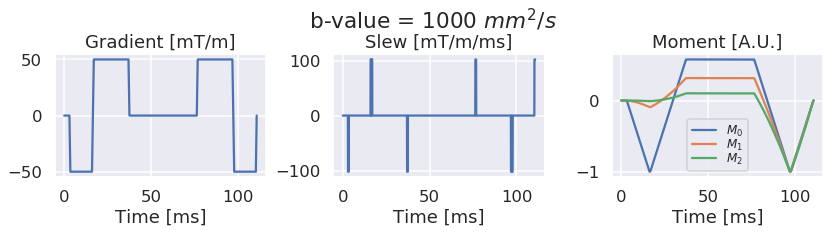

In [10]:
params = {}
params['mode'] = 'diff_bval'
params['gmax'] = 50            # Maximum gradient amplitude, mT/m
params['smax'] = 100           # Maximum slew rate, mT/m/ms
params['T_readout'] = 20       # Time from start to center of EPI readout, ms
params['T_90'] = 3             # Duration of excitation pulse, ms
params['T_180'] = 5            # Duration of refocusing pulse, ms
params['b'] = 1000             # Diffusion b-value, s/mm^2
params['dt'] = 400e-6

# ************
# M0, M1 and M2 nulling
# ************
params['MMT'] = 2              # Nulling M0, M1 and M2


# Convex Optimized Diffusion Encoding (CODE)
G_min, T_min = get_min_TE(params, bval=params['b'], min_TE = 40, max_TE = 120)
print('Minimum TE =', round(T_min,2), 'ms')
plot_waveform(G_min, params, plot_moments = True, plot_eddy = False, plot_pns = False, plot_slew = True)
plt.show(plot_waveform)

# Conventional Asymmetric Bipolar
AsymmBipolar, TE, b, params = asymmbipolar_diffusion(params)
params['TE'] = TE/100 + params['T_readout']*1000
print('Minimum TE =', round(params['TE'],2), 'ms')
plot_waveform(AsymmBipolar, params, plot_moments = True, plot_eddy = False, plot_pns = False, plot_slew = True)
plt.show(plot_waveform)

#### We can also constrain PNS for diffusion

Minimum TE = 68.36 ms


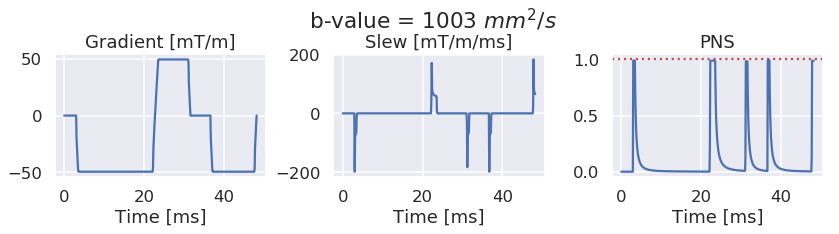

In [11]:
params = {}
params['mode'] = 'diff_bval'
params['gmax'] = 50
params['MMT'] = 0
params['T_readout'] = 20.0
params['T_90'] = 3
params['T_180'] = 5
params['dt'] = 100e-6
bval = 1000

# ************
# Use maximum slew rate
# ************
params['smax'] = 200.0

# ************
# Add PNS contraint
# ************
params['pns_thresh'] = 1.0


G_min, T_min = get_min_TE(params, bval, min_TE = 40, max_TE = 120)
print('Minimum TE =', round(T_min,2), 'ms')
plot_waveform(G_min, params, plot_moments = False, plot_eddy = False, plot_pns = True, plot_slew = True)

#### We can also constrain to null for a specific eddy current time constants (lambda) to null diffusion incuded eddy currents

Minimum TE = 86.64 ms


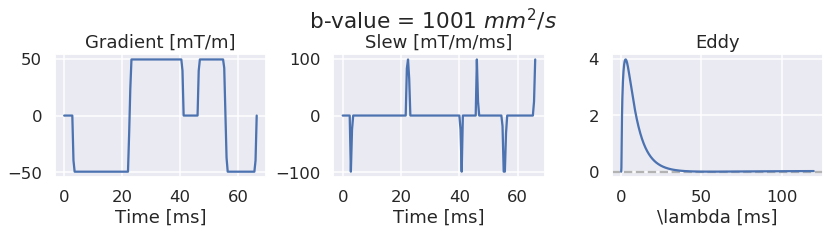

In [12]:
params = {}
params['mode'] = 'diff_bval'
params['MMT']  = 0
params['gmax']  = 50
params['smax']  = 100.0
params['T_readout']  = 20.0
params['T_90']  = 3
params['T_180']  = 5
params['dt']  = 400e-6
bval = 1000

# ************
# Null eddy current for lambda time constant = 80ms
# ************
params['eddy_params']  = [[80.0, 0.0, 1.0e-4, 0.0]]


G_min, T_min = get_min_TE(params, bval, min_TE = 80, max_TE = 120)
print('Minimum TE =', round(T_min,2), 'ms')
plot_waveform(G_min, params, plot_moments = False, plot_eddy = True, plot_pns = False, plot_slew = True)